# Linear Regression with Iterative optimization: SGDRegressor

SGD offers a lot of control over optimization procedure through a number of hypeparameters. However, we need to set them to right values in orderto make it work for training the model.

In [4]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
np.random.seed(306)

We will use ShuffleSplit as a cross validation strategy.

In [19]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

Let's load the data and split it into train and test

In [6]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features,labels,random_state=42)

Divide the data into train and dev sets.

In [7]:
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

#Baseline SGDRegressor

1. To begin with, we instantiate a baseline SGDRegressor model with default parameters.
2. Train the model with training feature matrix and labels
3. Obtain the score on the following and devel data.

In [9]:
sgd = SGDRegressor(random_state=42)
sgd.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd.predict(dev_features))
print(train_mae, dev_mae)

312995824045833.75 315394681503071.94


Training error is too high

# Adding a feature scaling step

SGD is sensitive to feature scaling. Let's add a feature scaling steps and check if we get better MAE.

In [10]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                         ('sgd',SGDRegressor())])
sgd_pipeline.fit(train_features, train_labels)

train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae, dev_mae)

0.7935259642528993 1.5185221399033502


The error is still high, let's run SGDRegressor step by step and investigate issues with training.

# Step-wise training of SGDRegressor

1. Instantiate SGDRegressor with warm_start=True and tol=-np.infty
2. Train SGD step by step and record regression loss in each step
3. Plot learning curves and see if there are any issues in training

Text(0.5, 1.0, 'Learning curve: eta0=0.0100')

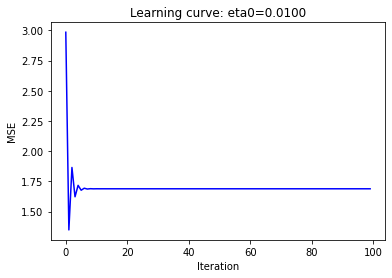

In [12]:
eta0 = 1e-2
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                         ('SGD',SGDRegressor(max_iter=1, tol=-np.infty,
                                             warm_start=True,
                                             random_state=42))])
loss=[]
for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels,
                                 sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

loss reduced and increased, perhaps due to large learning rate, so we will try with a lower learning rate

Text(0.5, 1.0, 'Learning curve: eta0=0.0010')

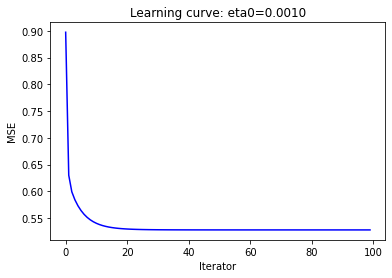

In [15]:
eta0 = 1e-3
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                         ('SGD',SGDRegressor(max_iter=1, tol=-np.infty,
                                             warm_start=True, eta0= eta0,
                                             random_state=42))])
loss=[]
for epoch in range(100):
  sgd_pipeline.fit(train_features, train_labels)
  loss.append(mean_squared_error(train_labels,
                                 sgd_pipeline.predict(train_features)))

plt.plot(np.arange(len(loss)), loss, 'b-')
plt.xlabel('Iterator')
plt.ylabel('MSE')
plt.title(f'Learning curve: eta0={eta0:.4f}')

An ideal learning curve

In [16]:
#Iterations before reaching convergence
print(sgd_pipeline[-1].n_iter_)

#Weight updates
print(sgd_pipeline[-1].t_)

1
11611.0


In [17]:
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae, dev_mae)

0.5333732983042573 0.5190150280908042


# Fixing learning rate through validation curves

1. Provide a list of hyper-parameters
2. Instantiate an object of validation_curve with estimator, training features and label. Set scoring parameter to relevant score.
3. Convert scores to error
4. Plot validation curve with the value of hyper-parameter on x-axis and error on the y-axis
5. Fix the hyper-parameter value where the test error is the least. 

In [31]:
%%time
eta0 = [1e-5,1e-4,1e-3,1e-2]
train_scores, test_scores = validation_curve(sgd_pipeline, com_train_features, com_train_labels, param_name = 'SGD__eta0',
                                             param_range=eta0, cv=shuffle_split_cv,scoring='neg_mean_squared_error',
                                             n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

CPU times: user 265 ms, sys: 12.4 ms, total: 277 ms
Wall time: 665 ms


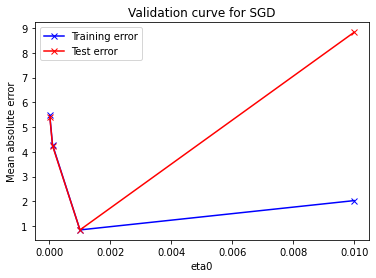

In [36]:
train_errors, test_errors = -1*train_scores, -1*test_scores
plt.plot(eta0, train_errors.mean(axis=1),'b-x',label='Training error')
plt.plot(eta0, test_errors.mean(axis=1),'r-x',label='Test error')
plt.legend()
plt.xlabel('eta0')
plt.ylabel('Mean absolute error')
_=plt.title('Validation curve for SGD')

For eta=1e-3 the test error is the least and hence we select that value as the value for eta0
Next we plot std dev in errors

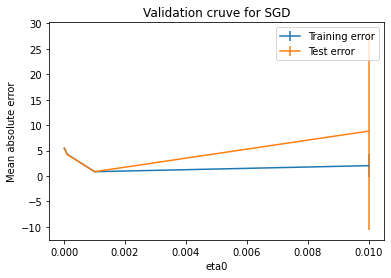

In [37]:
plt.errorbar(eta0, train_errors.mean(axis=1), yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(eta0, test_errors.mean(axis=1), yerr=test_errors.std(axis=1), label='Test error')
plt.legend()

plt.xlabel('eta0')
plt.ylabel('Mean absolute error')
_=plt.title('Validation cruve for SGD')

# SGDRegressor

In [38]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae,dev_mae)

0.579376454514559 0.5689180241137523


In [39]:
print(sgd_pipeline[-1].n_iter_,sgd_pipeline[-1].t_)

7 81271.0


In [41]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae,dev_mae)

0.5359339681114987 0.5151099728924144


In [42]:
print(sgd_pipeline[-1].n_iter_,sgd_pipeline[-1].t_)

8 92881.0


In [44]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=500,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='adaptive',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae,dev_mae)

0.5340193046836148 0.5198356196858102


In [45]:
print(sgd_pipeline[-1].n_iter_,sgd_pipeline[-1].t_)

33 383131.0


#Setting max_iters

In [46]:
max_iter = np.ceil(1e6/com_train_features.shape[0])
max_iter

65.0

In [47]:
sgd_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                        ('sgd',SGDRegressor(max_iter=max_iter,
                                            early_stopping=True,
                                            eta0=1e-3,
                                            tol=1e-3,
                                            learning_rate='constant',
                                            validation_fraction=0.2,
                                            n_iter_no_change=5,
                                            average=10,
                                            random_state=42))])
sgd_pipeline.fit(train_features, train_labels)
train_mae = mean_absolute_error(train_labels, sgd_pipeline.predict(train_features))
dev_mae = mean_absolute_error(dev_labels, sgd_pipeline.predict(dev_features))
print(train_mae,dev_mae)

0.5359339681114987 0.5151099728924144


In [48]:
print(sgd_pipeline[-1].n_iter_,sgd_pipeline[-1].t_)

8 92881.0
